### 目標－求假設C值下的母體標準差
* 透過Black-scholes公式 (參數: S、K、r、T) 以及樣本標準差，計算結果得報酬率 C 
* 不斷嘗試帶入>0 的浮點數至樣本標準差計算 (利用二分法計算可大幅減少運算時間)
* 直到計算結果 C 與假設的C值相等，此時帶入的 樣本標準差值 = 假設C值下的母體標準差

### 公式－Black-scholes formula
* C = SN*(d1) - ke ** (-rT)次方 * N(d2)
* 其中 d1 = [ ln(S/K) + (r + σ/2) T ] / σ√T ， d2 = d1 - σ√T
* N(z) 為標準常態分配之累積累積分配函數 (cdf)

### 變數設定
* 參數 S、K、r、T = S、K、r、T
* 公式 d1、d2、N(d1)、N(d2) = d1、d2、N_d1、N_d2
* 樣本標準差： SD_sample
* 計算結果市價： C_sample
* 母體標準差： SD_population
* 假設市價C值： C_population

In [1]:
# 導入模組

import time
import math
from scipy.stats import norm   # 計算cdf norm.cdf(z,loc = 0 ~平均值,scale = 1~標準差) 求cdf


In [2]:
def calculate_call(S, K, r, T, sigma):
    d1 = ((math.log(S/K) + (r + pow(sigma,2)/2)*T)) / (sigma*pow(T,0.5))
    N_d1 = norm.cdf(d1)
    d2 = d1 - sigma*pow(T,0.5)
    N_d2 = norm.cdf(d2)
    call_value = S*N_d1 - K*math.exp(-r*T)*N_d2
    return call_value

In [3]:
S = 100
K = 110
r = 0.05
T = 0.25
# sigma = 0.2

sigma_list = []
call_value_list = []
for i in range(1000):
    sigma = (i+1)/100
    call_value = calculate_call(S, K, r, T, sigma)
    
    sigma_list.append(sigma)
    call_value_list.append(call_value)
    

<AxesSubplot:>

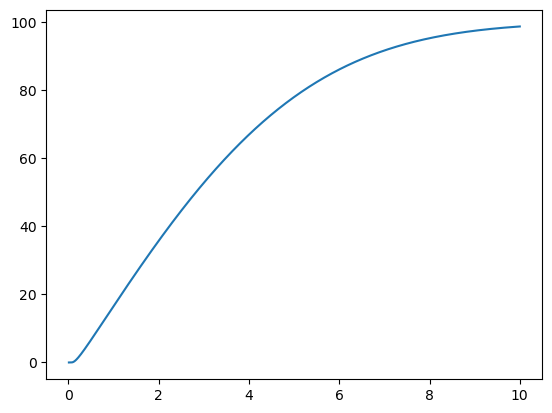

In [4]:
import pandas as pd
series = pd.Series(call_value_list, index=sigma_list)
series.plot()

In [5]:
def calculate_implied_volatility(call, S, K, r, T, error):
    
    start = time.time()              # 時間計算
    print('起始時間：',start)
    
    # i、j 為目標 sigma 所在範圍的上下界
    i = 0.0001
    j = 10
    while not (call - calculate_call(S, K, r, T, i))/call < error :  # 確認call與範圍內最小值運算結果之間差值佔call的百分比是否在容許誤差內
        
        if call < calculate_call(S, K, r, T, (i+j)/2) > error :    # 如果 call 比範圍內中間值的運算結果小
            j = (i+j)/2                                            # 則判斷目標在範圍內的前50%
        else :                                                     # 如果 call 沒有比範圍內中間值的運算結果小
            i = (i+j)/2                                            # 則判斷目標在範圍內的後50%
    
    sigma = i     # 若 i 的運算結果與 call 比對後在誤差範圍內，i 即是尋找目標 sigma
    
    end = time.time()                 # 時間計算
    print('結束時間：',end)
    print('執行時間：',end - start )
    
    return sigma

In [6]:
error = 0.00001   # 可容許誤差率
S = 100
K = 110
r = 0.05
T = 0.25
call = float(input('假設的 call 值：'))
sigma_target = calculate_implied_volatility(call, S, K, r, T, error)
print('假設call為',call,'的情況下，sigma為',sigma_target)

假設的 call 值：0.5
起始時間： 1677172326.5445397
結束時間： 1677172326.580444
執行時間： 0.0359044075012207
假設call為 0.5 的情況下，sigma為 0.14715212882161138


In [7]:
S = 100
K = 110
r = 0.05
T = 0.25
sigma = sigma_target
print(calculate_call(S, K, r, T, sigma))

0.49999947323897587


# 公式撰寫

def Black_scholes(SD_sample) :
    
    S = 100
    K = 110
    r = 0.05
    T = 0.25
    
    d1 = (math.log(S/K) + (r + SD_sample**2/2)*T) / (SD_sample*pow(T,0.5))
    N_d1 = norm.cdf(d1)
    d2 = d1 - SD_sample*pow(T,0.5)
    N_d2 = norm.cdf(d2)
    C_sample = S*N_d1 - K*math.exp(-r*T)*N_d2
    
    return C_sample


In [8]:
# N = 10              # 帶入的標準差的最大值
# error = 0.0004      # C 值間的容許誤差

# C_max = Black_scholes(N)
# C_population = C_max+1
# while C_population > C_max :
#    print('請輸入 0 到',C_max,'之間的數')
#    C_population = float(input('假設市價 C 值：'))


# 二分法

def SD(C_population) :
    
    start = time.time()              # 時間計算
    print('起始時間：',start)
    
    i = 0.00001
    j = N
    
    while C_population - Black_scholes(i) > error :   # 確認 C_population 與範圍內最小值的運算結果是否相等
        
        if C_population < Black_scholes((i+j)/2) :    # 如果 C_population 比範圍內中間值的運算結果小
            j = (i+j)/2                               # 則判斷目標在範圍內的前50%
        else :                                        # 如果 C_population 沒有比範圍內中間值的運算結果小
            i = (i+j)/2                               # 則判斷目標在範圍內的後50%
        
    end = time.time()                 # 時間計算
    print('結束時間：',end)
    print('執行時間：',end - start )
    
    
    # 若 i 的運算結果與 C_population 比對後在誤差範圍內，i 即是尋找目標 SD_sample
    return i                          # 回傳 i

* ans_SD_sample = SD(C_population)
* SD_population = ans_SD_sample
* print('假設市價為',C_population,'的情況下，標準差為',SD_population)

## 出圖教學

import pandas as pd

series = pd.Series([1,2,3,4,5], index=[10,20,30,40,50])
series.plot()